In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous
from scipy.stats import f
from prettytable import PrettyTable
import datetime
import os # to save file to a selected directories, which do not need to be created
import scipy.special as ss
from scipy.optimize import minimize

class frechet_gen(rv_continuous):
    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))

frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [11]:
Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
}
data { 
  int N;
  real y[N]; 
}
parameters { 
  //parameters of the Fisher
  real<lower=1> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta; 
}

model {
  // when we deliberately do not specify priors then Stan works with improper priors

  alpha1 ~ gamma(5,5);
  //target +=// change
  target +=  - 2 * log(alpha2);   //-log(alpha2 + 1) - 1/2 * (log(alpha2) + log(alpha2 + 2));
  target += log(1/beta);

// Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}
generated quantities{}
"""

In [2]:
q = [0.98, 0.99, 0.995, 0.999, 0.9995]
beta_frechet = 1/2
quant_th = np.zeros(len(q))
for i in range(len(q)):
    quant_th[i] = pow(-log(q[i]), -beta_frechet)

def PWM_GPD(excesses, k, u):
    quant_PWM_GPD = np.zeros(len(q))
    sum1, sum2 = 0, 0
    for i in range(k):
        sum1 += excesses[i]
        sum2 += i * excesses[i]
    mu0 = sum1 / k
    mu1 = sum1 / k - sum2 / k / k
    sigma = 2 * mu0 * mu1 / (mu0 - 2 * mu1)
    gamma = (mu0 - 4 * mu1) / (mu0 - 2 * mu1)
    for i in range(len(q)):
        quant_PWM_GPD[i] = u + sigma / gamma *( pow( N * (1-q[i]) / k, -gamma ) - 1 ) 
    return(quant_PWM_GPD)

def MOM_Fisher(excesses, k, u):
    "i use notation: tau0 = EX, tau1 = m12 / m_12, tau2 = m34 / m_34"
    quant_MOM_Fisher = np.zeros(len(q))
    c0 = 1 / k * np.sum(excesses)
    c1 = np.sum([pow(x,1/2) for x in excesses])/np.sum([pow(x,-1/2) for x in excesses])
    c2 = np.sum([pow(x,3/4) for x in excesses])/np.sum([pow(x,-1/4) for x in excesses])

    alpha2_prim = (c2 - c0) / 2/(-c0 -  c1 + 2 * c2)
    alpha1_prim = (c1 * alpha2_prim)/ 2 / (c0 * (alpha2_prim - 1/2) - alpha2_prim * c1)

    alpha1 = alpha1_prim + 1/2
    alpha2 = alpha2_prim + 1/2
    beta = c1 * (alpha2 - 1/2) / (alpha1 - 1/2)

    beta0 = alpha2/alpha1
    for i in range(len(q)):
        quant_MOM_Fisher[i] = u +  f.isf(N / k * (1 - q[i]), 2 * alpha1, 2 * alpha2, loc = 0, scale = beta / beta0)
    return(quant_MOM_Fisher)

def MOM_GPD(excesses, k, u):
    quant_MOM_GPD = np.zeros(len(q))
    c0 = 1 / k * np.sum(excesses)
    c1 = np.sum([pow(x,1/2) for x in excesses]) / np.sum([pow(x,-1/2) for x in excesses])
#     c2 = np.sum([pow(x,3/4) for x in excesses])/np.sum([pow(x,-1/4) for x in excesses])
    alpha2 = (c1 - c0) / (2 * c1 - c0)
    beta = c0 * (alpha2 - 1)
#     alpha2 = alpha2_prim + 1/2
    for i in range(len(q)):
        quant_MOM_GPD[i] = u + beta * ( pow( N * (1 - q[i]) / k, - 1 / alpha2 ) - 1 )
    return(quant_MOM_GPD)

#MLE for GPD
def fun(x, df):
    kk = len(df)
    log_arg = sum([log(1 + x * y) for y in df])
    return kk * log(1 / kk / x * log_arg) + log_arg + kk

def MLE_GPD(excesses, k, u):
    quant_MLE_GPD = np.zeros(len(q))
    # constraints: x > 0
    abstol = 1e-6
    cons = ({'type': 'ineq', 'fun': lambda x: x - abstol})

    tau = minimize(fun, 2, args=excesses, constraints = cons, method='SLSQP')
    gamma = 1 / len(excesses) * sum([log(1 + tau.x * y) for y in excesses])
    sigma = gamma / tau.x
#     print("alpha = ", 1/gamma, "\n beta = ", sigma / gamma)
    
    for i in range(len(q)):
        quant_MLE_GPD[i] = u + sigma / gamma * ( pow( N * (1 - q[i]) / k, - gamma ) - 1 )
    return(quant_MLE_GPD)
    
   

In [13]:
chain_length = 1000
burn_up = 200
def quantiles_Fisher(excesses, k, u):
    plug_in_median_Fisher = np.zeros(len(q)) 
    
    # here we fit Fisher to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=chain_length,warmup=burn_up, chains=1) 
    
    # we save the params from the fit to calculate Fisher quantiles and their traceplots to calculate Bayesian Fisher quantiles
    traceplot_alpha1 = list(fit.extract().values())[0].tolist()
    traceplot_alpha2 = list(fit.extract().values())[1].tolist()
    traceplot_beta = list(fit.extract().values())[2].tolist()
    
    alpha1 = np.mean(list(fit.extract().values())[0].tolist())
    alpha2 = np.mean(list(fit.extract().values())[1].tolist())
    beta = np.mean(list(fit.extract().values())[2].tolist())
    
    beta0 = alpha2/alpha1
    beta0_plugin = np.median(traceplot_alpha2)/np.median(traceplot_alpha1)
    
    for i in range(len(q)):
        plug_in_median_Fisher[i] = u +  f.isf(N / k * (1 - q[i]), 2 * np.median(traceplot_alpha1), 2 * np.median(traceplot_alpha2), loc = 0, scale = np.median(traceplot_beta) / beta0_plugin)

    return(plug_in_median_Fisher) 

In [4]:
def k_greatest_values_matrices(a,k):
    """returns k greatest elements from the list a and k - 1 value starting from which we consider greater values as extremes"""
    # we prepare the matrix for the excesses, the last value of 1 could be substituted by any value within the range
    mat = np.zeros( len(a[-1 - k + 1 : , 1] ) ) 
    # we prepare the vector in which we will return u values for each dataset in column of a
    u = np.zeros(len(r[0 , : ] )) 
    for i in range(len(a[0,:])): 
        # index i goes through the columns, instead of len(a[0,:]) there could be len(a[i,:]) for i in range of columns
        u[i] = a[-1 - k, i] 
        # u is a list of values s.t. bigger values are considered as excesses, for each set of data, i.e. for each column we save an u value
        mat = np.column_stack( (mat,a[ -1 - k + 1 : , i]) ) 
    # in mat matrix we return the values of excesses but not yet transformed (y_i = x_i - u)
    return(mat, u) # u is the starting value from which we consider others as excesses

In [5]:
n = 20 # number of sampled datasets over which we average the quantiles
how_many_different_thresholds =15
min_thresholds = 100
max_thresholds = 500
N = 1000

r = frechet.rvs(beta_frechet, size=N) 
for i in range(n):
    r = np.column_stack( (r, frechet.rvs(beta_frechet, size=N) ) ) 

# we need to sort in increasing order sampled data
for i in range(len(r[0,:])):
    r[:,i] = np.sort(r[:,i], axis=None)

In [6]:
# astype function converts the values in the array to integers
jump_excesses = np.linspace(min_thresholds, max_thresholds, how_many_different_thresholds).astype(int) 

now = datetime.datetime.now() # we take it globally to save all the tables and plots in one directory
concatenated_MOM_Fisher = np.zeros(len(q))
concatenated_plugin_bayes_Fisher = np.zeros(len(q))

In [7]:
for j in range(len(jump_excesses)): # for different threshold of excesses
    k = jump_excesses[j]
    data_frechet, u = k_greatest_values_matrices(r,k) 
    # delete first column (indexed by 0) of a matrix A, to match the sizes 
    A = np.delete(data_frechet, 0, 1)
    # form the array of u values we create matrix, in columns we have repeated u values   
    B = [ [x] * k for x in u ] 
    # here we subtract u_i from excesses in each dataset
    C = np.array(A) - np.array(B).transpose() 
    
    averaged_MOM_Fisher = np.zeros(len(q))
    
    for i in range(n): 
        # we fit GPD and Fisher distributions to excesses from each dataset
        excesses_array = C[:,i] 
        averaged_MOM_Fisher += 1 / n * MOM_Fisher(excesses_array, k, u[i])
  
    concatenated_MOM_Fisher = np.column_stack((concatenated_MOM_Fisher,averaged_MOM_Fisher))

concatenated_MOM_Fisher = np.delete(concatenated_MOM_Fisher, 0,1) # this delete appears often, it may be written as a separate function?


In [14]:
# if the above produces nice plots for non-Bayesian Fisher we turn attention to Bayesian Fisher 

for j in range(len(jump_excesses)): # for different threshold of excesses
    k = jump_excesses[j]
    data_frechet, u = k_greatest_values_matrices(r,k) 
    # delete first column (indexed by 0) of a matrix A, to match the sizes 
    A = np.delete(data_frechet, 0, 1)
    # form the array of u values we create matrix, in columns we have repeated u values   
    B = [ [x] * k for x in u ] 
    # here we subtract u_i from excesses in each dataset
    C = np.array(A) - np.array(B).transpose() 
    
    averaged_plugin_bayes_Fisher = np.zeros(len(q))
    
    for i in range(n): 
        # we fit GPD and Fisher distributions to excesses from each dataset
        excesses_array = C[:,i] 
        averaged_plugin_bayes_Fisher += 1 / n * quantiles_Fisher(excesses_array, k, u[i])
  
    concatenated_plugin_bayes_Fisher = np.column_stack((concatenated_plugin_bayes_Fisher,averaged_plugin_bayes_Fisher))

concatenated_plugin_bayes_Fisher = np.delete(concatenated_plugin_bayes_Fisher, 0,1) # this delete appears often, it may be written as a separate function?


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a8d496d89dbf5a0fcfc422de4803c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_492a

<Figure size 432x288 with 0 Axes>

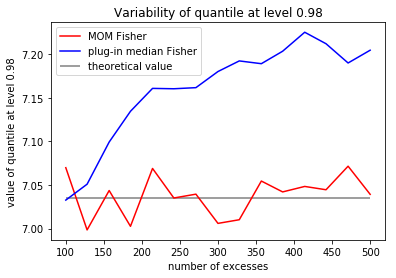

<Figure size 432x288 with 0 Axes>

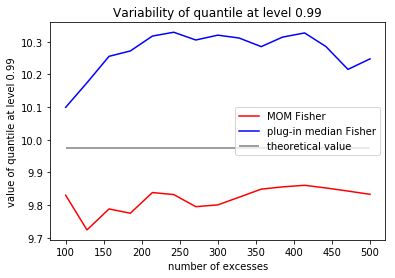

<Figure size 432x288 with 0 Axes>

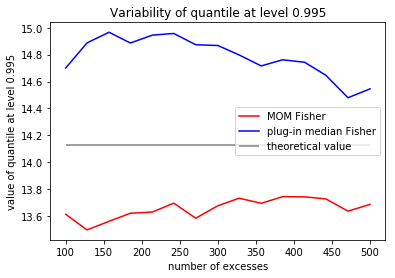

<Figure size 432x288 with 0 Axes>

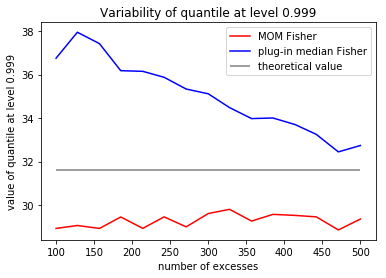

<Figure size 432x288 with 0 Axes>

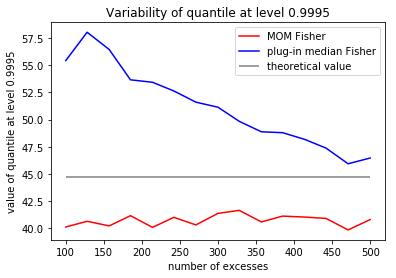

In [16]:
for i in range(len(q)):
    fig = plt.figure()
#     ax = fig.add_subplot(111)
    
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
    name = " quant_level_" + str(q[i])
    script_dir = os.path.dirname('__file__')
    results_dir = os.path.join(script_dir, dir_name + '/')
    sample_file_name = name + '.pdf'
    fig = plt.figure()
    if not os.path.isdir(results_dir): # if the directory does not exist we create it 
        os.makedirs(results_dir)
    ax = fig.add_subplot(111)
    fig.savefig(results_dir + sample_file_name ) 
    
    plt.hlines(y=quant_th[i], 
               xmin=min(jump_excesses), 
               xmax=max(jump_excesses), 
               color='gray', 
               zorder=1, 
               label='theoretical value')
    
    plt.plot(jump_excesses, concatenated_MOM_Fisher[i,:], 'red', label='MOM Fisher')
    plt.plot(jump_excesses, concatenated_plugin_bayes_Fisher[i,:], 'blue', label='plug-in median Fisher')
#     plt.plot(jump_excesses, concatenated_PWM_GPD[i,:], 'aqua', label='PWM GPD')
#     plt.plot(jump_excesses, concatenated_MLE_GPD[i,:], 'mediumblue', label='MLE GPD')
    
    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(q[i]))
    plt.title('Variability of quantile at level ' + str(q[i])  )
    plt.legend()#     plt.savefig(results_dir + sample_file_name)
    
    plt.savefig(results_dir + sample_file_name)

plt.show()